In [1]:
from IPython.display import Markdown as md  # jupyter md
import matplotlib as mpl

In [2]:
import scanpy as sc
import seaborn as sns

In [3]:
# 设置参数
mpl.rcParams["pdf.fonttype"] = 42  # 保留字体
sc.settings.verbosity = 4  # 输出细节
sc._settings.ScanpyConfig.n_jobs = -1  # 使用所有核心
sc.settings.set_figure_params(
    dpi=80,
    dpi_save=600,
    facecolor="white",
    frameon=False,  # remove frame
)

# 预分析

- 1.加载数据
- 2.基本信息
- 3.标准质控
- 4.环境 RNA 校正（可选）
- 5.双峰检测


1.加载数据

- 1.1 导入 h5ad.gz 文件
- 1.2 导入 h5ad 文件
- 1.3 导入 10x 数据


In [4]:
## 2.1.2 读取
adata = sc.read("./adata_raw.h5ad")
adata.X = adata.X.astype("float")

adata.X

<111645x22250 sparse matrix of type '<class 'numpy.float64'>'
	with 179896733 stored elements in Compressed Sparse Column format>

normalizing counts per cell
    finished (0:00:00)


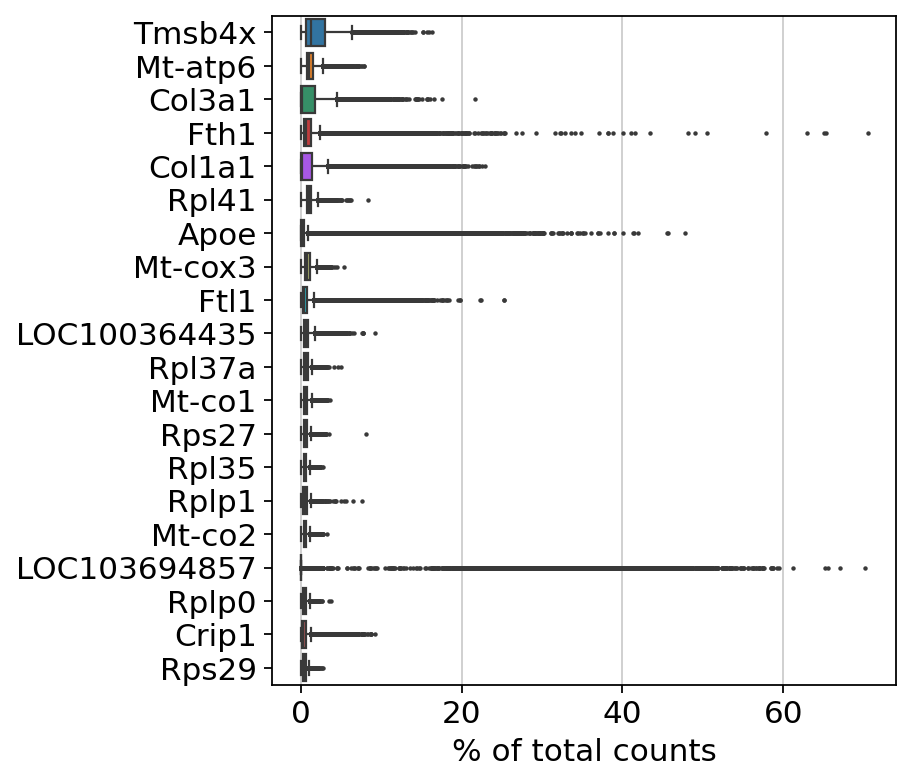

In [5]:
## 2.2 看基因在所有细胞中的表达情况
"""
    - 预期出现的基因类型,如 mitochondrial genes、actin、ribosomal protein 和 MALAT1。
    - 如果所有的外部控制转录本(spike-in transcripts)都在前50名中,可能意味着添加了过多的外部控制RNA。
    - 大量的伪基因或预测的基因可能暗示着在基因比对过程中可能存在问题。
"""
sc.pl.highest_expr_genes(adata, n_top=20)

3.标准质控

- 3.1 读取经过环境 RNA 校正、基础过滤、双联体过滤后的数据
- 3.2 识别线粒体基因、核糖体基因、血红蛋白基因
- 3.3 计算 QC 指标
- 3.4 绘制 QC 指标
- 3.5 定义离群值函数
- 3.6 检查一般参数的离群值 mad=5
- 3.7 检查线粒体基因的离群值 mad=3
- 3.8 过滤
- 3.9 QC 可视化
- 3.10 可选：手动质控
- 3.11 保存


In [6]:
## 3.2 识别线粒体基因、核糖体基因、血红蛋白基因
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")  # 忽略大小写
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.upper().str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"), case=False)

In [7]:
# 创建Markdown格式的字符串
markdown_text = f"""
**线粒体基因数量总和**: {adata.var["hb"].sum()}

**核糖体基因数量总和**: {adata.var["ribo"].sum()}

**血红蛋白基因数量总和**: {adata.var["hb"].sum()}
"""

# 显示Markdown内容
display(md(markdown_text))


**线粒体基因数量总和**: 11

**核糖体基因数量总和**: 127

**血红蛋白基因数量总和**: 11


In [8]:
## 3.3 计算QC指标
"""The three QC covariates:
    - total_counts: 库大小，过大的库可能是两个细胞的混合物
    - pct_counts_mt: 线粒体计数百分比
    - n_gene_by_counts: 细胞中至少有 1 个计数的基因数量
    -------------------------------
    如果一个细胞正在死亡,那么其mRNA被释放到内环境,导致线粒体基因的比例较高。
    但是,线粒体计数相对较高的细胞可能参与呼吸过程,不应被过滤掉。
    计数低或高的细胞可能对应于静止细胞群或尺寸较大的细胞。
    故我们在过滤低质量细胞的时候要同时考虑不同的QC协变量之间的关系。
    -------------------------------
    TODO:calculate_qc_metrics() inplace=True,注意第一个质控绘图的变化,可能数据已经被标准化了
"""
sc.pp.calculate_qc_metrics(
    # pp is preprocessing
    adata,
    qc_vars=["mt", "ribo", "hb"],
    inplace=True,  # False，则返回计算的指标作为 Pandas DataFrame。True，则将指标直接存储在输入的 AnnData 对象中，并不返回任何值。
    percent_top=(20, 50, 100, 200, 500),  # 默认值
    log1p=True,
)
adata

AnnData object with n_obs × n_vars = 111645 × 22250
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'keep', 'RNA_snn_res.0.3', 'RNA_snn_res.0.6', 'RNA_snn_res.1', 'RNA_snn_res.1.2', 'seurat_clusters', 'pANN', 'DF.classifications', 'RNA_snn_res.1.4', 'RNA_snn_res.1.6', 'cell_type', 'ident', 'sample', 'group', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'X_name'
    obsm: 'HARMONY', 'PCA', 'UMAP'
    layers: 'logcounts', 'scaledat

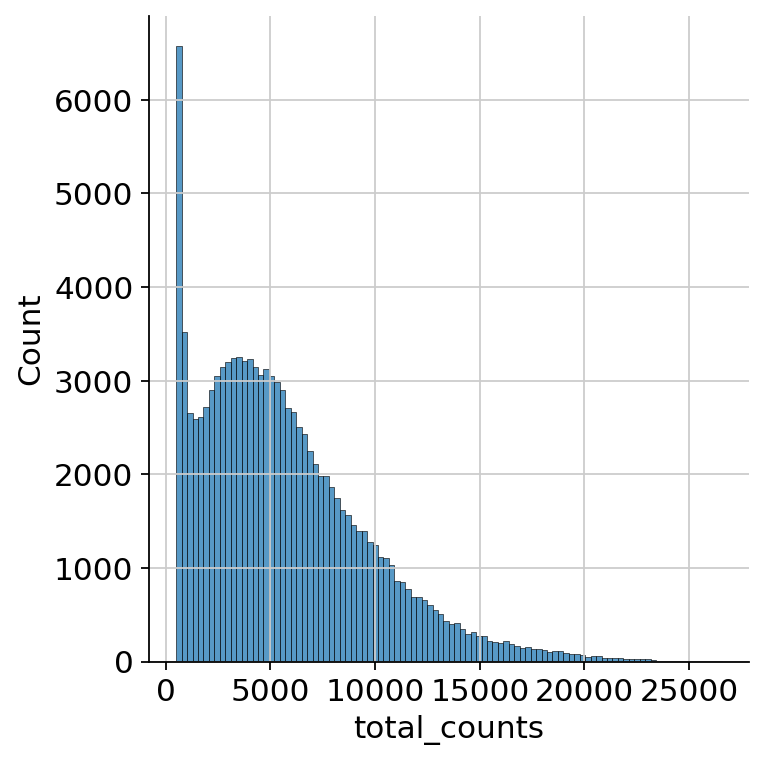

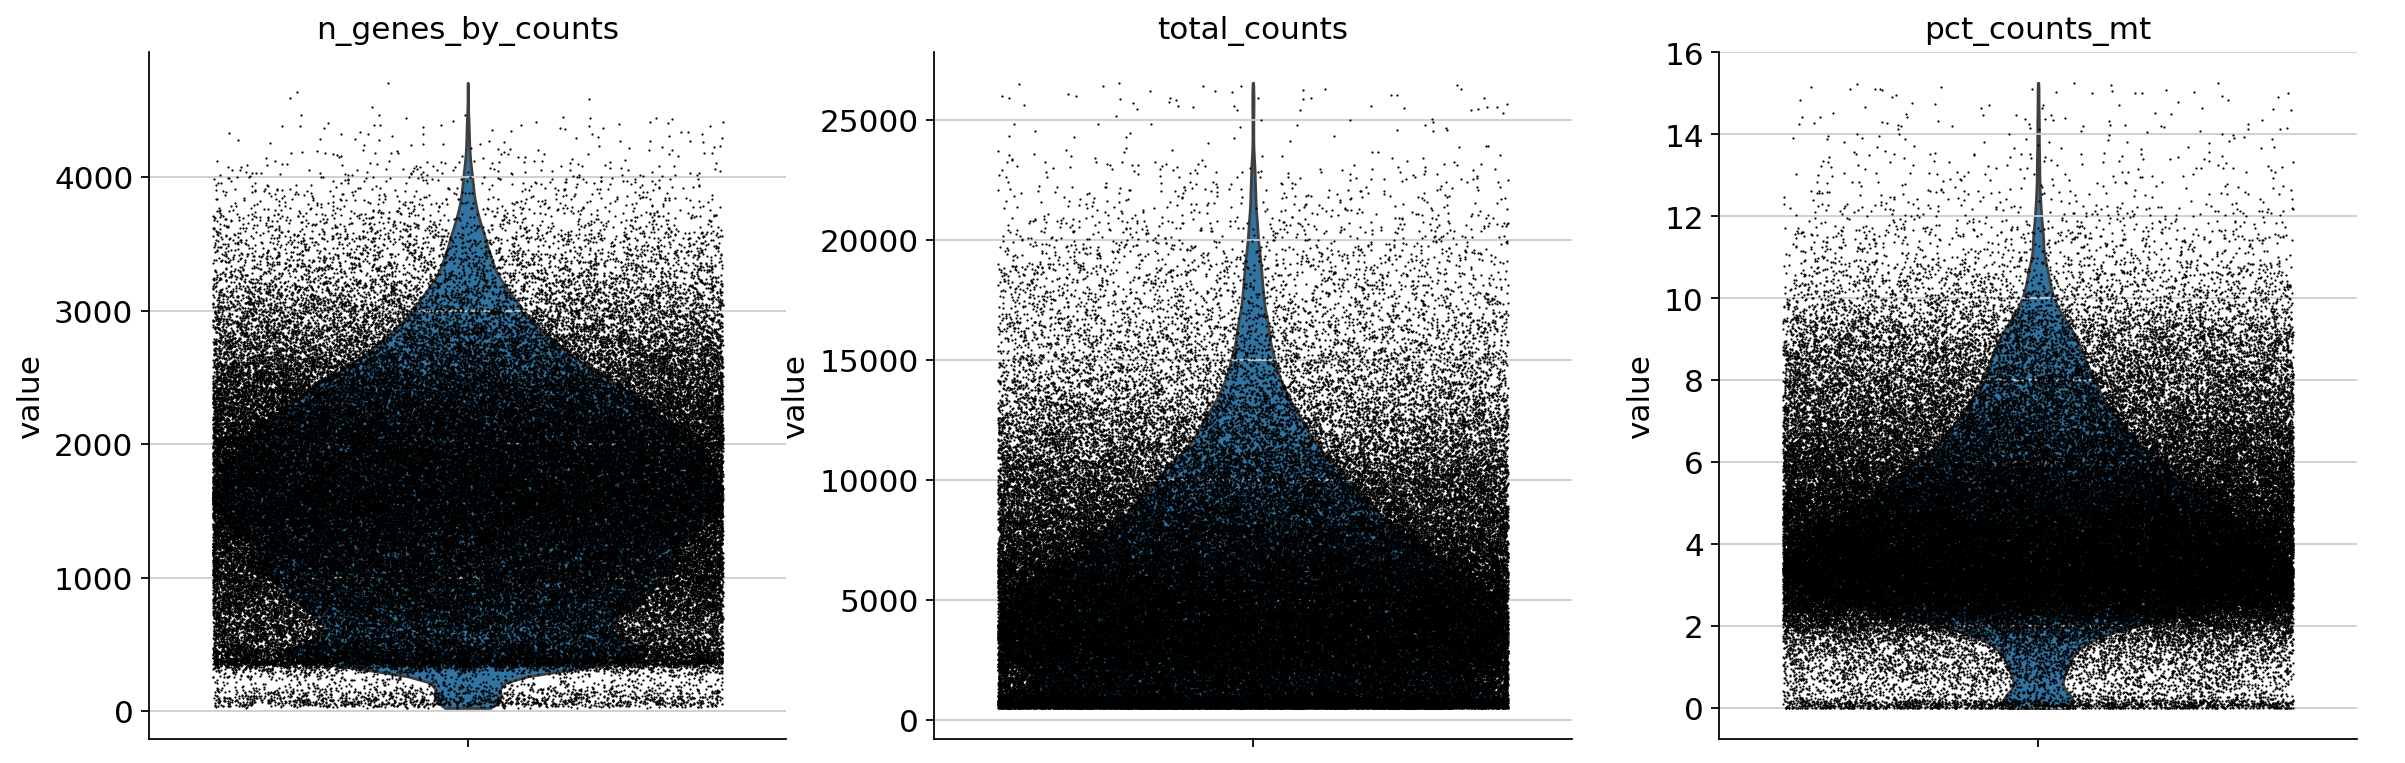

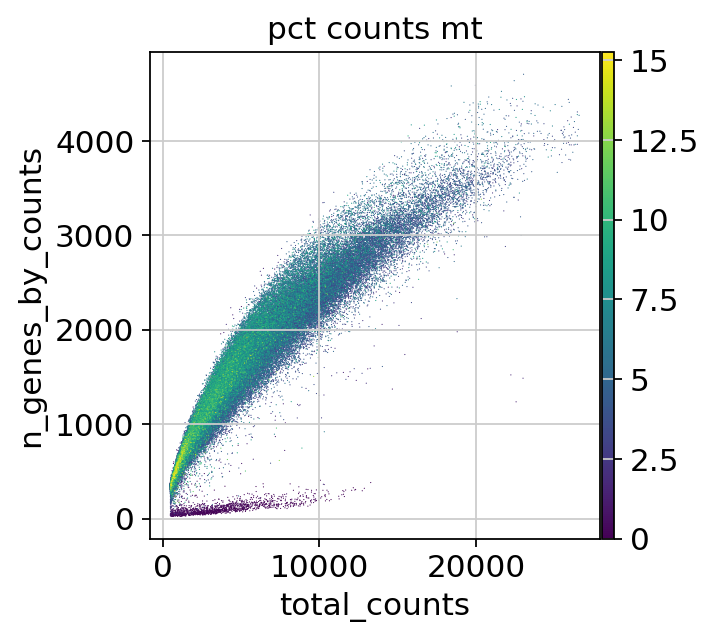

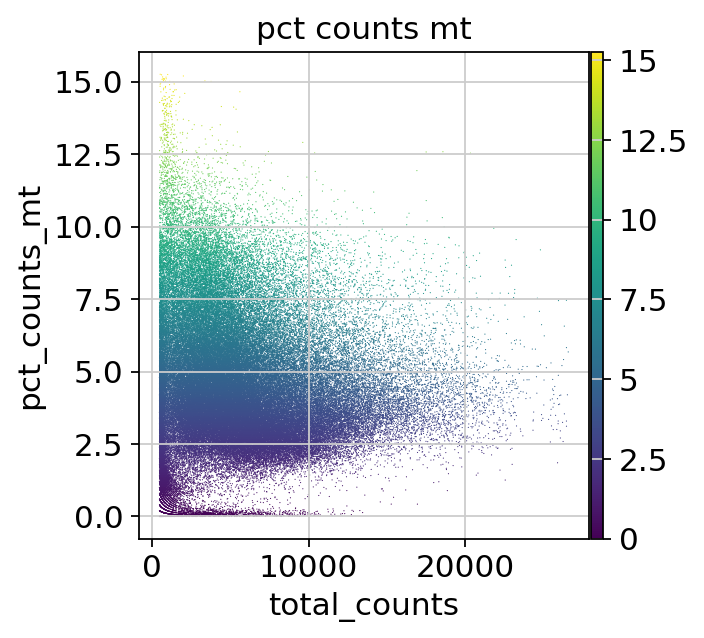

In [9]:
## 3.4 绘制QC指标
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)
# 画的有些多余
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
p4 = sc.pl.scatter(adata, "total_counts", "pct_counts_mt", color="pct_counts_mt")

In [10]:
## 3.5 定义离群值函数
import numpy as np
from scipy.stats import median_abs_deviation


def is_outlier(adata, metric: str, nmads: int):
    """
    Determines if a data point is an outlier

    Parameters:
        adata (AnnData): The annotated data object.
        metric (str): The name of the metric used to determine outliers.
        nmads (int): The number of median absolute deviations used to define outliers.

    Returns:
        outlier (bool): A boolean array indicating whether each data point is an outlier.
    """

    m_metric = adata.obs[metric]
    outlier = (
        m_metric < np.median(m_metric) - nmads * median_abs_deviation(m_metric)
    ) | (np.median(m_metric) + nmads * median_abs_deviation(m_metric) < m_metric)
    return outlier

In [11]:
## 3.5 定义离群值函数--多批次
import numpy as np
from scipy.stats import median_abs_deviation
import pandas as pd


def is_outlier_multibatch(adata, metric: str, nmads: int, batch_key: str):
    """
    Determines if a data point is an outlier within each batch.

    Parameters:
        adata (AnnData): The annotated data object.
        metric (str): The name of the metric used to determine outliers.
        nmads (int): The number of median absolute deviations used to define outliers.
        batch_key (str): The key in adata.obs used to define batches.

    Returns:
        outlier (pd.Series): A boolean array indicating whether each data point is an outlier within its batch.
    """

    # Get metric values and batch labels
    m_metric = adata.obs[metric]
    batches = adata.obs[batch_key]

    # Initialize an empty series to store outlier status for each data point
    outlier = pd.Series(index=m_metric.index, dtype=bool)

    # Loop over each batch to calculate outliers
    for batch in batches.unique():
        batch_idx = batches == batch
        batch_data = m_metric[batch_idx]

        # Calculate outlier status for this batch
        outlier_batch = (
            batch_data
            < np.median(batch_data) - nmads * median_abs_deviation(batch_data)
        ) | (
            np.median(batch_data) + nmads * median_abs_deviation(batch_data)
            < batch_data
        )

        # Store results in the main outlier series
        outlier[batch_idx] = outlier_batch

    return outlier

In [12]:
adata.obs.batch.unique()

['GSM6685496', 'GSM6685497', 'GSM6685498', 'GSM6685499', 'GSM6685500', ..., 'GSM6685524', 'GSM6685525', 'GSM6685526', 'GSM6685527', 'GSM6685528']
Length: 33
Categories (33, object): ['GSM6685496', 'GSM6685497', 'GSM6685498', 'GSM6685499', ..., 'GSM6685525', 'GSM6685526', 'GSM6685527', 'GSM6685528']

In [13]:
## 基础过滤
print(f"Total number of genes: {adata.n_vars}")
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 22250


filtered out 1487 cells that have less than 200 genes expressed
filtered out 4981 genes that are detected in less than 3 cells
Number of genes after cell filter: 17269


In [14]:
## 3.6 检查一般参数的离群值mad=5,更严格的参数mad=3，2
MAD = 3

# adata.obs["outlier"] = (
#     is_outlier(adata, "total_counts", MAD)
#     | is_outlier(adata, "n_genes_by_counts", MAD)
#     # | is_outlier_multibatch(adata, "pct_counts_in_top_20_genes", MAD, "batch")

# )


adata.obs["outlier"] = (
    is_outlier_multibatch(adata, "log1p_total_counts", MAD, "batch")
    | is_outlier_multibatch(adata, "log1p_n_genes_by_counts", MAD, "batch")
    # | is_outlier_multibatch(adata, "pct_counts_in_top_20_genes", MAD, "batch")
)

adata.obs.outlier.value_counts()

/tmp/ipykernel_3835596/2069362718.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False ... False False True]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  outlier[batch_idx] = outlier_batch
/tmp/ipykernel_3835596/2069362718.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False ... False False True]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  outlier[batch_idx] = outlier_batch


outlier
False    100603
True       9555
Name: count, dtype: int64

In [15]:
## 3.7 检查线粒体基因的离群值mad=3
# adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
#     adata.obs["pct_counts_mt"] > 20
# )

# adata.obs["mt_outlier"] = is_outlier_multibatch(adata, "pct_counts_mt", 3, "batch") | (
#     adata.obs["pct_counts_mt"] > 20
# )

adata.obs["mt_outlier"] = adata.obs["pct_counts_mt"] > 20

adata.obs.mt_outlier.value_counts()

mt_outlier
False    110158
Name: count, dtype: int64

In [16]:
## 3.8 过滤
print(f"Total number of cells: {adata.n_obs}")
# python 的~是取反
adata.obs["discard"] = adata.obs.outlier | adata.obs.mt_outlier
# 备份
unfiltered = adata.copy()
adata = adata[~adata.obs.discard].copy()
print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 110158
Number of cells after filtering of low quality cells: 100603


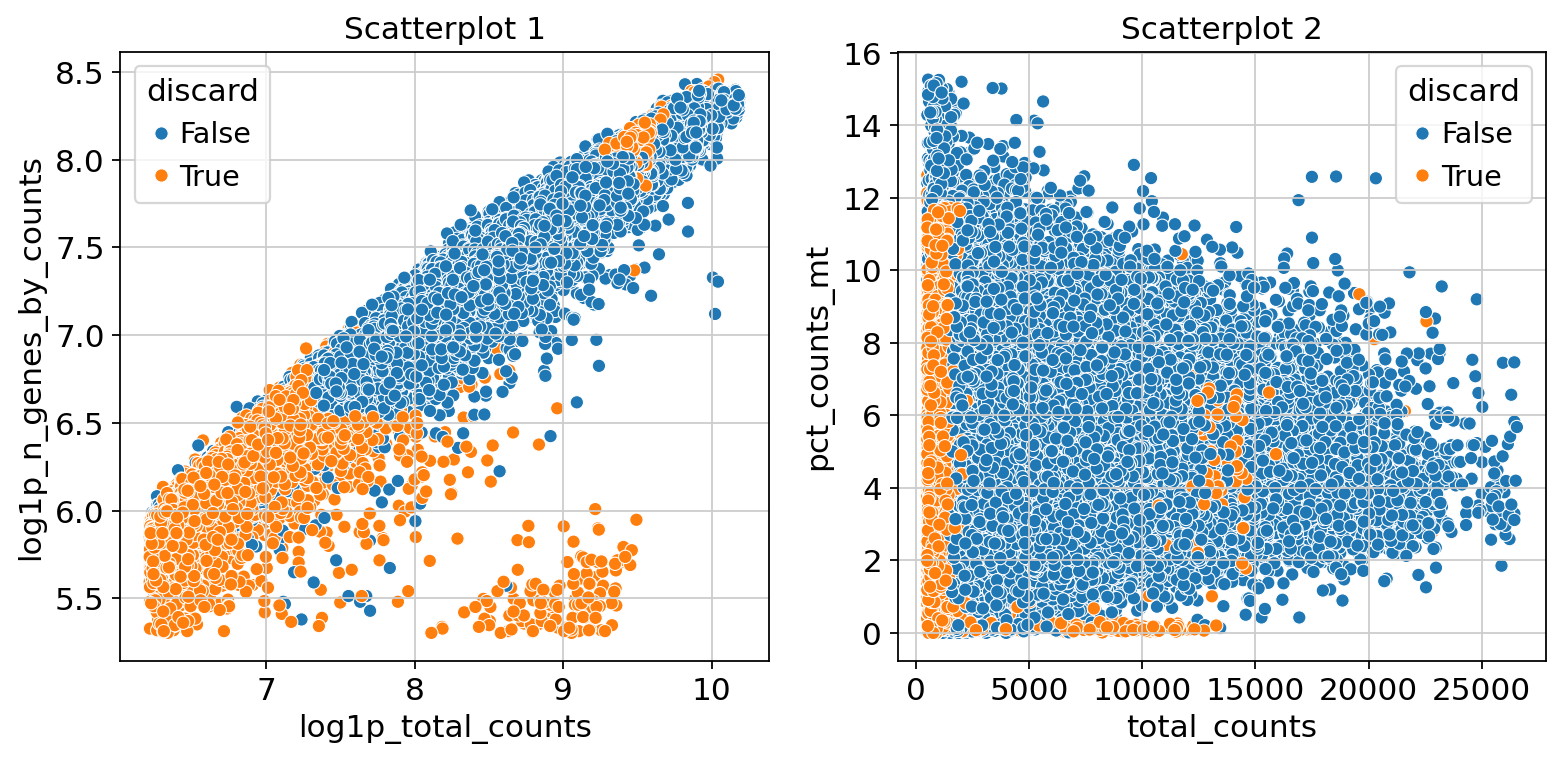

In [17]:
## 3.9 QC可视化
import matplotlib.pyplot as plt
import seaborn as sns
import os

# os.mkdir("figures")

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# sns.scatterplot(x='total_counts', y='log1p_n_genes_by_counts', hue='discard', data=unfiltered.obs, ax=axes[0])
# axes[0].set_title('Scatterplot 1')

sns.scatterplot(
    x="log1p_total_counts",
    y="log1p_n_genes_by_counts",
    hue="discard",
    data=unfiltered.obs,
    ax=axes[0],
)
axes[0].set_title("Scatterplot 1")

sns.scatterplot(
    x="total_counts", y="pct_counts_mt", hue="discard", data=unfiltered.obs, ax=axes[1]
)
axes[1].set_title("Scatterplot 2")

plt.tight_layout()  # 自动调整子图参数，使之填充整个图像区域
plt.savefig("figures/01-质控-诊断图-py.pdf")
plt.savefig("figures/01-质控-诊断图-py.tiff")
plt.show()
# 补充删失的细胞是否是有差异的诊断图参考bioconductor,见下方
#

In [18]:
## 3.10 保存
adata.write("anndata_qc.h5ad", compression="gzip")  # type: ignore

# 3.11 附加：拓展质控绘图和多批次质控


In [19]:
## 3.11.1 保存用于绘图已标记但未过滤的数据
# unfiltered.write("unfiltered.h5ad", compression="gzip")  # type: ignore

In [20]:
# ## 3.11.2 配置R环境
# import anndata2ri
# import logging

# import rpy2.rinterface_lib.callbacks as rcb
# import rpy2.robjects as ro

# rcb.logger.setLevel(logging.CRITICAL)
# ro.pandas2ri.activate()
# anndata2ri.activate()

# %load_ext rpy2.ipython

In [21]:
# %%R
# ## 3.11.3 读取，scanpy转sce
# library(SingleCellExperiment)
# library(zellkonverter)
# library(scater)

# unfiltered <- readH5AD("unfiltered.h5ad")
# counts(unfiltered)=assay(unfiltered,"X")
# unfiltered

In [22]:
# %%R
# unfiltered <- readH5AD("unfiltered.h5ad")
# counts(unfiltered)=assay(unfiltered,"X")
# unfiltered

In [23]:
# %%R
# ## 3.11.4
# # 诊断图1 ---------------------------------------------------------------
# qc_p1 <- gridExtra::grid.arrange(
#     plotColData(unfiltered,
#         y = "total_counts", colour_by = "discard",
#         other_fields = "group"
#     ) +
#         scale_y_log10() +
#         ggtitle("total_counts_log10(y)") + facet_wrap(~group),
#     plotColData(unfiltered,
#         y = "n_genes_by_counts", colour_by = "discard",
#         other_fields = "group"
#     ) +
#         scale_y_log10() +
#         ggtitle("Detected features") + facet_wrap(~group),
#     plotColData(unfiltered,
#         y = "pct_counts_mt", colour_by = "discard",
#         other_fields = "group"
#     ) +
#         ggtitle("Mito percent") + facet_wrap(~group),
#     ncol = 2
# )
# grid::grid.draw(qc_p1)
# ggsave("./figures/01-质控-诊断图-R-1.pdf", qc_p1, width = 10, height = 5)



In [24]:
# %%R
# ## 3.11.5
# # 诊断图2 ---------------------------------------------------------------
# # 还有一些可以画的图，使用a = colData(unfiltered) |> as.data.frame()—>ggplot()
# ## 确认不存在总计数和线粒体计数都较大的细胞
# qc_p2 <- gridExtra::grid.arrange(
#     plotColData(unfiltered,
#         x = "total_counts", y = "pct_counts_mt",
#         colour_by = "discard", other_fields = "group"
#     ) + facet_wrap(~group),

#     ### 好的细胞通常会表现为每个细胞有更多的基因和更高数量的UMI。
#     plotColData(unfiltered,
#         x = "total_counts", y = "log1p_n_genes_by_counts",
#         colour_by = "discard", other_fields = c("group", "pct_counts_mt")
#     ) + facet_wrap(~group) + scale_x_log10()
# )

# ggsave("./figures/01-质控-诊断图-R-2.pdf", qc_p2, width = 10, height = 5)


In [25]:
# %%R
# ## 3.11.6
# # 诊断图3:诊断细胞类型丢失 ---------------------------------------------------------------
# ## 看有没有去除有意义的细胞类型

# discard <- unfiltered$discard
# lost <- calculateAverage(counts(unfiltered)[, discard])
# kept <- calculateAverage(counts(unfiltered)[, !discard])
# ## diagnose cell type loss by looking for systematic differences
# library(edgeR)
# logged <- cpm(cbind(lost, kept), log = TRUE, prior.count = 2)
# log_fc <- logged[, 1] - logged[, 2]
# abundance <- rowMeans(logged)

# ## 如果丢弃的池中某种细胞类型富集，我们应该观察到相应标记基因的表达增加
# pdf("./figures/01-质控-诊断图-R-3.pdf", width = 5, height = 5)
# plot(abundance, log_fc,
#     xlab = "Average count", ylab = "Log-FC (lost/kept)",
#     pch = 16
# )
# points(abundance[discard], log_fc[discard], col = "dodgerblue", pch = 16)
# dev.off()


In [26]:
# %%R
# # 3.11.7 借助多样本质控
# # 一般的质控基于大多数细胞都是正常的假设，但有时候不是
# # 有spike gene添加时适合看这个
# library(scater)
# library(dplyr)

# ## 看要不要重新计算了离群值探索

# # discard_mult_mt <- isOutlier(unfiltered$pct_counts_mt,
# #     type = "higher", batch = unfiltered$batch #根据各自批次的离群值
# # )
# # discard_mult_counts <- isOutlier(unfiltered$total_counts,
# #     type = "both", batch = unfiltered$batch
# # )
# # discard_mult_umi <- isOutlier(unfiltered$n_genes_by_counts,
# #     type = "both", batch = unfiltered$batch
# # )

# # discard_mult <- discard_mult_mt | discard_mult_counts | discard_mult_umi

# qc_p4 <- gridExtra::grid.arrange(
#     plotColData(unfiltered,
#         x = "batch", y = "total_counts",colour_by = "discard"
#     ) + scale_y_log10() + ggtitle("Total counts by batch"),
#     plotColData(unfiltered,
#         x = "batch", y = "n_genes_by_counts",colour_by = "discard"
#     ) + scale_y_log10() + ggtitle("Detected features by batch"),
#     plotColData(unfiltered,
#         x = "batch", y = "pct_counts_mt",colour_by = "discard"
#     ) + ggtitle("Mito percent by batch")
#     ,
#     ncol = 1
# )
# grid::grid.draw(qc_p4)
# ggsave("./figures/01-质控-诊断图-R-4-多批次.pdf",qc_p4, width = 10, height = 5)


- 看到这里的图应该回去调整参数
- 显著的双峰问题没解决，可以粗暴的设置上限，但是下面有正经的双峰
